<a href="https://colab.research.google.com/github/chandrakanta-chaudhury/deep_learning/blob/master/inception_GPU_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:

from torchvision import models
inception=models.inception_v3(pretrained=True)
print(inception)


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:05<00:00, 20923211.88it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
for param in inception.parameters():
  param.requires_grad=False
  
  

In [0]:
#for auxilary outputs
num_classes=10
aux_in_features=inception.AuxLogits.fc.in_features
inception.AuxLogits.fc=nn.Linear(aux_in_features,num_classes)



In [7]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)
    

torch.Size([10, 768])
torch.Size([10])


In [0]:
in_features=inception.fc.in_features
inception.fc=nn.Linear(in_features,num_classes)


In [9]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [10]:
#change below as img size requires 299 
transform_train=transforms.Compose([transforms.RandomResizedCrop(299),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),])
transform_test=transforms.Compose([transforms.RandomResizedCrop(299),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),])
trainset=torchvision.datasets.CIFAR10(root='/home/chandrakanta/Downloads',train=True,download=True,transform=transform_train)
testset=torchvision.datasets.CIFAR10(root='/home/chandrakanta/Downloads',train=False,download=True,transform=transform_test)
batch_size=16
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

0it [00:00, ?it/s]

170500096it [00:02, 70684263.57it/s]                               


Files already downloaded and verified


In [0]:
inception=inception.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(inception.parameters(),lr=0.01)


In [0]:
def evaluation(dataloader,model):
  total,correct=0,0
  for data in dataloader:
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    outputs,aux_outputs=model(inputs) #model return tuple ,output ,aux output
    _,pred=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(pred==labels).sum().item()
  return  100 * correct /total

min loss 3.12
min loss 3.00
min loss 2.97
min loss 2.97
min loss 2.92
min loss 2.82
min loss 2.74
min loss 2.62
min loss 2.56
min loss 2.48
min loss 2.45
min loss 2.43
min loss 2.35
min loss 2.29
min loss 2.03
min loss 1.97
min loss 1.90
min loss 1.81
min loss 1.76
min loss 1.72
min loss 1.65
min loss 1.31
min loss 1.27
min loss 1.20
min loss 1.19
min loss 1.02
min loss 0.99
epoch: 0 1, test acc: 47.23,train acc: 47.30


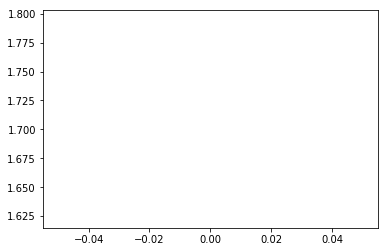

In [13]:
import copy
loss_epoch_arr=[]
max_epochs=1
min_loss=1000
n_iters=np.ceil(50000/batch_size)
for epoch in range(max_epochs):
  for i ,data in enumerate(trainloader,0):
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    opt.zero_grad()
    outputs,aux_outputs=inception(inputs)
    loss=loss_fn(outputs,labels) + 0.3 * loss_fn(aux_outputs,labels)
    loss.backward()
    opt.step()
    if min_loss > loss.item():
      min_loss=loss.item()
      best_model=copy.deepcopy(inception.state_dict())
      print('min loss %0.2f' % min_loss)
    if 1 % 100 == 0:
      print('iteration: %d/%d,loss: %0.2f' %(i,n_iters,loss.item()))
    del inputs,outputs,labels
    torch.cuda.empty_cache()
  loss_epoch_arr.append(loss.item())
  print('epoch: %d %d, test acc: %0.2f,train acc: %0.2f' %(epoch,max_epochs,evaluation(testloader,inception),evaluation(trainloader,inception)))
plt.plot(loss_epoch_arr)
plt.show()


In [14]:
inception.load_state_dict(best_model)
print(evaluation(trainloader,inception),evaluation(testloader,inception))

47.746 47.02
